Here we will improve on the simple GAN developed before to make a sine wave signal

In [1]:
import torch
import os
import matplotlib.pyplot as plt
from tqdm.notebook import trange
pi = 3.14159265359

In [2]:
# Labels:
T = 0.99
F = 0.01

### Resources for training: 
https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9

https://mc.ai/how-to-implement-gan-hacks-to-train-stable-generative-adversarial-networks/

## Define the networks

In [3]:
class Generator(torch.nn.Module):
    # Takes a value on the domain and makes a prediction.
    def __init__(self, nodecount, lr):
        super(Generator, self).__init__()
        self.latentsize = 10
        if isinstance(nodecount, int):
            self.layercount = layercount
            self.nodecount = [self.latentspace, nodecount, 2]
        elif isinstance(nodecount, list):
            self.layercount = len(nodecount)
            nodecount.insert(0, self.latentsize)
            nodecount.append(2)
            self.nodecount = nodecount
            
        self.layers     = torch.nn.ModuleList()
        self.batchnorm  = torch.nn.BatchNorm1d(self.latentsize)
        self.dropout    = torch.nn.Dropout(p=0.3)
        self.dropoutidx = 1
        
        # LeakyReLU is highly recommended for GANs
        self.activation = torch.nn.LeakyReLU(0.2)
        self.lr         = lr

        for i, layer in enumerate(range(self.layercount+1)):
            layer_to_add = torch.nn.Linear(self.nodecount[i], self.nodecount[i+1])
            torch.nn.init.normal_(layer_to_add.weight, mean=0, std=0.02)
            self.layers.append(layer_to_add)
                    
    def sample(self, batchsize, variance=1.0):
        return self(torch.autograd.Variable(torch.randn((batchsize, self.latentsize))*variance))
    
    def forward(self, x):
        x = self.batchnorm(x)
        for index, layer in enumerate(range(self.layercount)):
            if index == self.dropoutidx:
                x = self.dropout(x)
            x = self.activation(self.layers[layer](x))
        return self.layers[-1](x)
    
testlist = [4, 8, 9]
g = Generator(testlist, 0.1)
print(g)

Generator(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=9, bias=True)
    (3): Linear(in_features=9, out_features=2, bias=True)
  )
  (batchnorm): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): LeakyReLU(negative_slope=0.2)
)


In [4]:
class Discriminator(torch.nn.Module):
    # Takes a value on the domain and makes a prediction.
    def __init__(self, nodecount, lr):
        super(Discriminator, self).__init__()
        if isinstance(nodecount, int):
            self.layercount = layercount
            self.nodecount = [2, nodecount, 1]
        elif isinstance(nodecount, list):
            self.layercount = len(nodecount)
            nodecount.insert(0, 2)
            nodecount.append(1)
            self.nodecount = nodecount
            
        self.layers     = torch.nn.ModuleList()
        self.batchnorm  = torch.nn.BatchNorm1d(2)
        self.dropout    = torch.nn.Dropout(p=0.3)
        self.dropoutidx = 1
        
        #self.activation = torch.nn.ReLU()
        self.activation = torch.nn.LeakyReLU(0.2)
        self.lr         = lr

        for i, layer in enumerate(range(self.layercount+1)):
            layer_to_add = torch.nn.Linear(self.nodecount[i], self.nodecount[i+1])
            torch.nn.init.normal_(layer_to_add.weight, mean=0, std=0.02)
            self.layers.append(layer_to_add)
            
    def forward(self, x):
        x = self.batchnorm(x)
        for index, layer in enumerate(range(self.layercount+1)):
            if index == self.dropoutidx:
                x = self.dropout(x)
            x = self.activation(self.layers[layer](x))
        return torch.sigmoid(x)
    
testlist = [15, 188]
d = Discriminator(testlist, 0.1)
print(d)

Discriminator(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=188, bias=True)
    (2): Linear(in_features=188, out_features=1, bias=True)
  )
  (batchnorm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): LeakyReLU(negative_slope=0.2)
)


In [5]:
class GANtrainer():
    def __init__(self, generator, discriminator):
        super(GANtrainer, self).__init__()
        self.generator     = generator
        self.discriminator = discriminator
        self.genreps       = 2
        self.testfrequency = 5
        self.criterion     = torch.nn.BCELoss()
        
        self.true_label  = None
        self.fake_label  = None

    def getDomainValues(self, shape=None, limits=None):
        if shape is None:
            shape = (self.batchsize, 1)
        low, high = (0, 2*torch.pi) if limits == None else limits
        return torch.rand(shape)*(high - low) + low
    
    # Fitfunction to be declared outside of training agent
    def fitFunction(self, domainValues):
        pass
        
    def makeTrueData(self, shape, limits):
        true_domain  = self.getDomainValues(shape, limits)
        true_target  = self.fitFunction(true_domain)
        true_data    = torch.autograd.Variable(torch.cat((true_domain, true_target), -1))
        return true_data

    def train(self, epochs, batchsize, limits, prnt=False):
        self.epochs     = epochs
        self.batchsize  = batchsize
        self.limits     = limits
        self.true_label = torch.autograd.Variable(T*torch.ones(self.batchsize,1))
        self.fake_label = torch.autograd.Variable(F*torch.ones(self.batchsize,1))
        datashape = (self.batchsize, 1)
            
        self.discriminator_true_loss = []
        self.discriminator_fake_loss = []
        self.generator_loss          = []
        self.performance             = []
        
        epochdescriptor = trange(epochs, desc="Start training", leave=True, ncols=900)
        current_performance = 0
        for epoch in epochdescriptor:
            # Add noise to the labels for the discriminator (not required for generator):
            noisy_true = torch.FloatTensor(self.batchsize,1).uniform_(0.9, 1.0)
            noisy_fake = torch.FloatTensor(self.batchsize,1).uniform_(0, 0.1)
            # Add up to 5% of wrong labels:
            idx = noisy_true < 0.9 + 5/100 * (1.0 - 0.9)
            noisy_true[idx] = 1 - noisy_true[idx]
            idx = noisy_fake > 0.1 - 5/100 * (0.1 - 0.0)
            noisy_fake[idx] = 1 - noisy_fake[idx]
            
            # Train discriminator on true data:
            self.discriminator.zero_grad()
            true_data     = self.makeTrueData(datashape, limits)
            true_decision = self.discriminator(true_data)
            true_error    = self.criterion(true_decision, noisy_true)
            self.discriminator_true_loss.append(true_error.item())
            true_error.backward()

            # Train discriminator on fake data:
            fake_data     = self.generator.sample(self.batchsize).detach()
            fake_decision = self.discriminator(fake_data)
            fake_error    = self.criterion(fake_decision, noisy_fake)
            self.discriminator_fake_loss.append(fake_error.item())
            fake_error.backward()
            self.discriminator_optimizer.step()

            # Train only generator on discriminator's response, using flipped labels
            g_loss = 0
            for genrep in range(self.genreps):
                self.generator.zero_grad()
                generator_data     = self.generator.sample(self.batchsize)
                generator_decision = self.discriminator(generator_data)
                generator_error    = self.criterion(generator_decision, self.true_label)
                g_loss             = g_loss + generator_error.item()
                generator_error.backward()
            self.generator_optimizer.step()
            self.generator_loss.append(g_loss/self.genreps)
            
            # Test the performance:
            if epoch % self.testfrequency == 0:
                current_performance = self.test(50, prnt=False)
                self.performance.append(current_performance)
                if epoch > epochs/2 and current_performance > 0.95:
                    break
                
            epochdescriptor.set_description("G = {:.3f}, D_true = {:.3f}, D_fake = {:.3f}, % = {:.2f}".format(
                self.generator_loss[-1], self.discriminator_true_loss[-1], self.discriminator_fake_loss[-1],
                current_performance))
            epochdescriptor.refresh()
                        
        if prnt:
            fig = plt.figure(figsize=(10,5))
            plt.title('GAN training losses')
            plt.plot(range(epochs), self.generator_loss, label='Generator loss')
            plt.plot(range(epochs), self.discriminator_true_loss, label='Discriminator true loss')
            plt.plot(range(epochs), self.discriminator_fake_loss, label='Discriminator fake loss')
            #plt.plot(range(0,epochs,self.testfrequency), self.performance, label='Performance')

            plt.grid('True')
            plt.legend()
    
    def test(self, batchsize, prnt=True):
        self.generator.eval()
        datashape   = (batchsize, 1)
        true_domain = self.getDomainValues(datashape, self.limits)
        true_value  = self.fitFunction(true_domain)
        
        prediction  = self.generator.sample(batchsize).detach()
        pred_domain = prediction[:,0].reshape(batchsize, 1)
        pred_target = prediction[:,1].reshape(batchsize, 1)

        pred_labels = torch.round(self.discriminator(prediction).detach())
        pred_true   = torch.where(pred_labels >= 0.9)[0]
        pred_fake   = torch.where(pred_labels <= 0.1)[0]
        
        if prnt:
            fig = plt.figure(figsize=(10,5))
            plt.title('Testing the trained GAN')
            plt.scatter(true_domain, true_value)
            plt.scatter(pred_domain, prediction[:,1])
            plt.scatter(pred_domain[pred_true], pred_target[pred_true], c='g')
            plt.scatter(pred_domain[pred_fake], pred_target[pred_fake], c='r')
            plt.grid('True')

            plt.show()
            plt.close()
        else:
            return pred_true.numel()/batchsize


## Training setup:

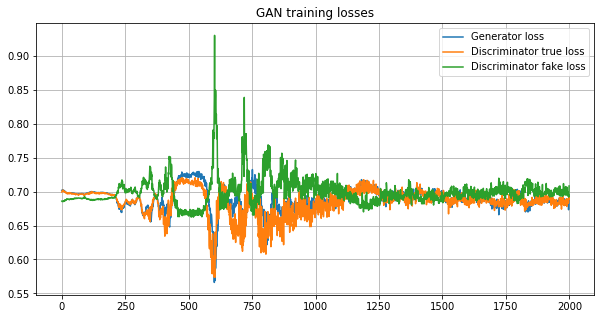

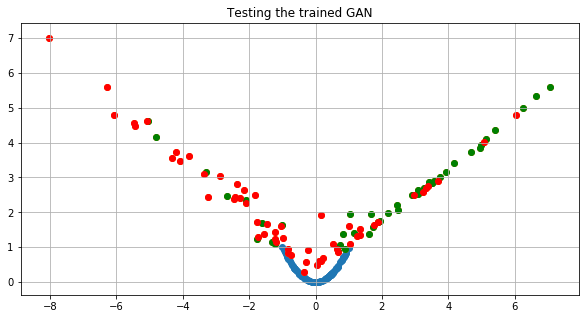

In [6]:
g = Generator([25], 0.005)
d = Discriminator([25], 0.002)

def square(x):
    return x*x

trainer = GANtrainer(g, d)
trainer.fitFunction = square

trainer.generator_optimizer = torch.optim.Adam(g.parameters(), lr=g.lr, weight_decay=1.0e-4)
trainer.discriminator_optimizer = torch.optim.Adam(d.parameters(), lr=d.lr, weight_decay=1.0e-4)

trainer.train(epochs=2000, batchsize=32, limits=(-1, 1), prnt=True)

trainer.test(100)
#os.system("beep -f 555 -l 460")